<a href="https://colab.research.google.com/github/joaochenriques/IST_MCTE/blob/main/Barrages/SimulEbbGeneration_2024_V03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as mpl
from typing import Callable, List, Tuple
import pathlib, os

try:
    from dataclassy import dataclass
except ModuleNotFoundError:
    os.system( "pip install dataclassy")
    from dataclassy import dataclass

If you are running Python on a Windows operating system, you may need to copy the file

https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py

to the working folder before running the notebook.

To print the notebook use:
```jupyter nbconvert SimulEbbGeneration_2024_V02.i
pynb --to webpdf```

in the command line.

In [2]:
if not pathlib.Path("mpl_utils.py").exists():
  os.system( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )

import mpl_utils as mut
mut.config_plots()

mpl.rcParams["figure.figsize"] = (12, 3)

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

# Configuration class

All config data is stored in this class

In [19]:
@dataclass
class Config:

    #===========================================================================
    # turbine data
    n_turbs: int = 24           # [-] number of turbines
    Dturb: float = 6.0          # [m] turbine diameter
    turb_CD: float = 0.65       # [-] turbine discharge coeff as sluice gate
    Omega: float                # [rad/s] synchronous rotational speed

    #===========================================================================
    # generator data
    grid_freq: float = 50.0     # [Hz] electrical grid frequency
    ppoles: int = 32            # [-]  Number of pole pairs of the generator
    Pgen_rated: float = 25E6    # [W]  generator rated power

    #===========================================================================
    # sluice gates data
    n_gates: int = 8            # [-]  number of sluice gates
    Agates: float = 10.0*15.0   # [m²] sluice gates area
    sluice_CD: float = 0.65     # [-]  sluice gates discharge coeff

    #===========================================================================
    # coeffs of the quadratic polynomial that describes the basin area
    # [ a, b, c ] => a*z**2 + b*z + c
    # The zero corresponds to the mean water level
    basin_coeffs = np.array( [ -0.102996E6, 1.272972E6, 23.31E6 ] )

    basin_z0 = 1.0              # [m] initial basin level

    #===========================================================================
    # tide components
    A: npt.NDArray = np.array( [ 4.18, 1.13 ] )               # [m] amplitudes
    ω: npt.NDArray = np.array( [ 0.5058/3600, 0.5236/3600 ] ) # [rad/s] frequencies
    φ: npt.NDArray = np.array( [ -3.019, -3.84 ] )            # [rad] phases
    global_period: float # [s] simulations' repetition period

    #===========================================================================
    delta_t = 100.0   # [s] integration time step
    simul_time: float # [s]

    #===========================================================================
    # state-space config - number of variables and outputs
    # DO NOT CHANGE!
    n_SS_vars = 4
    n_SS_outs = 9

    #===========================================================================
    def __init__( self ):

      # change if more than two tidal waves are used in the simulations
      self.Omega = 2 * np.pi * self.grid_freq / self.ppoles

      if len( self.ω ) == 2:
        self.global_period = 1.0 / np.abs( np.max( self.ω[1] ) \
                                 - np.min( self.ω[0] ) ) * 2.0 * np.pi
      else:
        self.global_period = 1.0 / self.ω[0] * 2.0*np.pi

      self.simul_time = 4.0*self.global_period

    ## HELPER FUNCTION #########################################################
    # Minimum turbine head that starts turbine generation.
    # Can be time dependent instead of a constant.
    def turbine_starting_head( self, t: float ) -> float:
      return 5.0

## Tide modelling

The tide level is assumed to be a trignometric series

$$\zeta(t) = \sum_i^n A_i \cos\left( \omega_i t + \phi_i \right).$$

In [20]:
@dataclass
class TideModel:

  # A_tide, period and φ_tide are vectors to allow simulate multi-component tides
  def __init__( self, A_tide: npt.NDArray, ω_tide: npt.NDArray, φ_tide: npt.NDArray ) -> None:
      self.A_tide = A_tide
      self.ω_tide = ω_tide
      self.φ_tide = φ_tide

  # tide level as a function t
  def level( self, t: float ) -> float:
      return np.sum( self.A_tide * np.cos( self.ω_tide * t + self.φ_tide ) )

# Tide period

Period: 353.0H, Neap tide amp: 3.05m, Spring tide amp: 5.31m


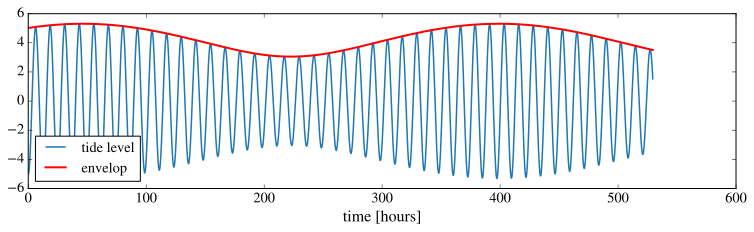

In [24]:
cfg = Config()

if len( cfg.ω ) == 2:
    tide = TideModel( cfg.A, cfg.ω, cfg.φ )

    period = cfg.global_period
    ev_time_vec = np.linspace( 0, 1.5*period, int( period / 100 ) )
    ζ_vec = np.zeros_like( ev_time_vec )

    for i, t in enumerate(ev_time_vec):
        ζ_vec[i] = tide.level( t )

    X1 = cfg.A[0]
    X2 = cfg.A[1]
    ωm = cfg.ω[0] - cfg.ω[1]
    φm = cfg.φ[0] - cfg.φ[1]
    ev = np.sqrt(X1**2 + X2**2 + 2*X1*X2*np.cos( ωm*ev_time_vec + φm ) )

    ev_time_vec /= 3600.0

    mpl.plot( ev_time_vec, ζ_vec, label="tide level" )
    mpl.plot( ev_time_vec, ev, 'r-', lw=2, label="envelop" )

    mpl.xlabel( 'time [hours]' )
    mpl.legend(loc='lower left')

    mpl.savefig('TimeSeriesTides.pdf', bbox_inches='tight', pad_inches=0) # pdflatex
    mpl.savefig('TimeSeriesTides.svg', bbox_inches='tight', pad_inches=0) # Word

    print( f'Period: {period/3600:.1f}H, Neap tide amp: {np.min(ev):.2f}m, Spring tide amp: {np.max(ev):.2f}m' )
else:
  print( "WARNING: Envelop only available for two tidal waves." );

# General description of the power plant's models

## Barrage simulator in ebb mode

The following models were implemented to simulate the tidal power plant:

* The basin
* The tide
* Hydraulic turbines
* Electrical generators
* Sluice gates
* Power plant controller

## Turbine model
### Turbine hill map and turbine operating curve

The turbine model uses the maximum power curve, ie., the red and gree lines of the turbine hill map.
The isolines of the efficiency are plotted as $\eta/\eta_\text{bep}$, where is $\eta_\text{bep}=0.912$.

<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/Barrages/TurbineGeneratorMaps/TurbineHill_Plot.svg" width="500px" style="display:inline">


### Turbine mode

Turbine dimensionless numbers

* Rotational speed $$n_{11}=\dfrac{\Omega D}{\sqrt{gh}}=\dfrac{C_0}{\sqrt{h}}.$$

* Flow rate $$Q_{11} = \dfrac{Q}{D^2\sqrt{gh}}=\dfrac{Q}{C_1\sqrt{h}}.$$

* Efficiency $$\eta_\mathrm{turb} = \dfrac{P_\mathrm{turb}}{P_\mathrm{avail}}.$$

where $C_0=\Omega D / \sqrt{g}$ and $C_1=D^2\sqrt{g}$.


The power available to the turbine is given by

$$P_\mathrm{avail} = \rho g h Q,$$

where

$$Q = D^2 \sqrt{gh} \, Q_{11}\!\big( n_{11} \big)=C_1 \sqrt{h} \, Q_{11}\!\big( n_{11} \big).$$

The turbine is to be operated at constant rotational speed due to the use of a synchronous generator (see generator class).

The available energy is

$$\dfrac{\text{d} E_\text{avail}}{\text{d}t} = P_\text{avail}.$$

The energy harvest by the turbine is

$$\dfrac{\text{d} E_\text{turb}}{\text{d}t}=\eta_\text{turb}\big( n_{11}\big) \, P_\text{avail},$$

The mean turbine efficiency is

$$\overline{\eta_\text{turb}} = \dfrac{E_\text{turb}}{E_\text{avail}}.$$

### Sluicing mode

The in sluicing mode the "turbine" is modelled as

$$Q_\mathrm{turb}^\mathrm{sluice} = C_\mathrm{d} A_\mathrm{turb} \sqrt{ 2 g h }$$

where $A_\mathrm{turb}$ is the area corresponding to the turbine rotor diameter.



In [ ]:
@dataclass
class TurbineModel:

  # flow rate: red line of the map
  poly_CQ1: np.poly1d = np.poly1d( np.array([0.16928201, 0.08989368]) )

  # flow rate: green line of the map
  poly_CQ2: np.poly1d = np.poly1d( np.array([-3.63920467e-04,  9.37677378e-03,
                                         -9.25873626e-02,  1.75687197e+00]) )

  # efficiency: red line of the map
  poly_CE1: np.poly1d = np.poly1d( np.array([-0.02076456, 0.20238444,
                                              0.48984553]) )
  # efficiency: green line of the map
  poly_CE2: np.poly1d = np.poly1d( np.array([-2.75685709e-04,  2.04822984e-03,
                                             6.86081825e-04,  7.93083108e-01]) )

  η_max: float = 0.912  # [-] maximum efficiency

  # n11 interpolation domain
  n11_min: float =  4.38    # [-]
  n11_max: float = 17.17    # [-]
  n11_r2g: float =  7.92193 # [-] red to green point

  # other data
  ga: float = 9.8         # [m/s²] gravity aceleration
  ρw: float = 1025.0      # kg/m³] water density
  CD_sluice: float        # [-] sluice mode discharge coefficient

  #=============================================================================
  def __init__( self, D_turb, Omega, CD_sluice ) -> None:

    self.Omega = Omega    # we are assuming constant rotational speed model
    self.D_turb = D_turb  # turbine rotor diameter
    self.A_turb = np.pi*(D_turb/2.0)**2

    # constants used in for computing n11 and QT
    self.C_0 = Omega * D_turb / np.sqrt( self.ga )
    self.C_1 = D_turb**2 * np.sqrt( self.ga )

    self.CD_sluice = CD_sluice

  def n11_range( self ) -> tuple:
    return ( self.n11_min, self.n11_max )

  # dimensionless velocity
  def n11( self, h: float ) -> float:
    # avoid division by zero on h = 0.0
    return self.C_0 / np.sqrt( max( h, 1E-3 ) )

  # dimensionless flow rate
  def Q11( self, n11: float ) -> float:
    assert( n11 >= self.n11_min ), "n11 small than admissable minimum"
    assert( n11 <= self.n11_max ), "n11 greater than admissable maximum"
    if n11 < self.n11_r2g:
      return self.poly_CQ1( n11 )
    else:
      return self.poly_CQ2( n11 )

  # efficiency
  def eta( self, n11: float ) -> float:
    assert( n11 >= self.n11_min ), "n11 small than admissable minimum"
    assert( n11 <= self.n11_max ), "n11 greater than admissable maximum"
    if n11 < self.n11_r2g:
      return self.poly_CE1( n11 ) * self.η_max
    else:
      return self.poly_CE2( n11 ) * self.η_max

  # computing operational data
  def operating_point( self, h: float ) -> Tuple:
    n11 = self.n11( h )
    Q_turb  = self.C_1 * self.Q11( n11 ) * np.sqrt( h )
    P_avail = self.ρw * self.ga * h * Q_turb
    η_turb  = self.eta( n11 )
    return ( Q_turb, P_avail, η_turb )

  # turbine flow rate in sluice mode
  def sluicing( self, h: float ) -> float:
    QS = -self.CD_sluice * self.A_turb * np.sqrt( 2.0 * self.ga * max( -h, 0.0 ) )
    return QS

## Generator efficiency curve

The electrical generator is assumed to be a synchronous machine. The rotational speed is given by

$$\Omega = \dfrac{2\pi f_\mathrm{g}}{n_\mathrm{p}}$$

where $f_\mathrm{g}$ is the electrical grid frequency and $n_\mathrm{p}$ is the number of pairs of poles.

<br />

The generator efficiency is computed as a function of the load

$$\Lambda = \dfrac{P_\mathrm{turb}}{P_\mathrm{gen}^\mathrm{rated}}$$


<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/Barrages/TurbineGeneratorMaps/GeneratorEff_plot.svg" width="400px" style="display:inline">

Electrical power output is

$$P_\mathrm{gen} =\eta_\mathrm{gen}(\Lambda) \, P_\mathrm{turb},$$

and the converted energy is

$$\dfrac{\mathrm{d} E_\mathrm{gen}}{\mathrm{d} t} = P_\mathrm{gen}.$$

The mean generator efficiency is

$$\overline{\eta_\mathrm{gen}}=\dfrac{E_\mathrm{gen}}{E_\mathrm{turb}}.$$



In [ ]:
@dataclass
class GeneratorModel:

  # red part of the curve
  poly_C1: np.poly1d = np.poly1d( np.array([-6.71448631e+03,  2.59159775e+03,
                                            -3.80834059e+02,  2.70423225e+01,
                                             3.29394948e-03]) )
  # green part of the curve
  poly_C2: np.poly1d = np.poly1d( np.array([-1.16856952,  3.31172525,
                                            -3.44296217,  1.5416029 ,
                                             0.71040716]) )

  Pgen_rated: float # [W] Generator rate power

  #=============================================================================
  def __init__( self, Pgen_rated: float ) -> None:
    self.Pgen_rated = Pgen_rated

  # efficiency as a function of the load
  def eta( self, P_turb: float ) -> float:
    load = P_turb / self.Pgen_rated

    assert( load >= 0.0 ),  "turbine power lower than zero"
    assert( load <= 1.0 ), f"generator rated power to low ({P_turb})"
    if load < 0.12542:
      return self.poly_C1( load )
    else:
      return self.poly_C2( load )

## Sluice gates

The sluice gates are modelled as a turbulent pressure drop

$$Q_\mathrm{sluice} = C_\mathrm{d} A \sqrt{ 2 g h }$$

typical discharge coefficients for barrage sluice gates are within the range $0.6 \le C_\mathrm{d} \le 1.2$.

In the follwoing model, it is assumed that the sluice gates are closed when the sea level is below the basin level $(h\ge 0)$.

In [ ]:
@dataclass
class GateModel:
  ga: float = 9.8   # [m/s²]
  CD_sluice: float  # [-]

  #=============================================================================
  def __init__( self, Area: float, CD_sluice ) -> None:
    self.Area = Area
    self.CD_sluice = CD_sluice

  # flow rate as a function of h
  def sluicing( self, h: float ) -> float:
    QS = -self.CD_sluice * self.Area * np.sqrt( 2.0 * self.ga * max( -h, 0.0 ) )
    return QS

## Basin modelling


<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/Barrages/Figures/BasinShoeBox_MWL.svg" width="300px" style="display:inline">


<br/>


The instantaneous basin volume is computed from

$$\dfrac{\mathrm{d}V}{\mathrm{d}t}=-Q(t).$$

The out flow is denoted as positive.

<br />

Let $z(t)$ be the water level with respect to the mean water level (MWL) and $A_\mathrm{basin}(z)$ the basin area as a function of $z(t)$.

<br />

Knowing that $V=z \, A_\mathrm{basin}(z)$, the basin volume change as function of time is computed as

$$
\dfrac{\mathrm{d}V}{\mathrm{d}t}
=\dfrac{\mathrm{d}(z \, A_\mathrm{basin}(z))}{\mathrm{d}t}
=\dfrac{\mathrm{d}z}{\mathrm{d}t}A_\mathrm{basin}(z) + z\,\dfrac{A_\mathrm{basin}(z)}{\mathrm{d}z}\dfrac{\mathrm{d}z}{\mathrm{d}t}
= f_\mathrm{basin}(z)\dfrac{\mathrm{d}z}{\mathrm{d}t}
$$

where

$$f_\mathrm{basin}(z)=A_\mathrm{basin}(z) + z\,\dfrac{A_\mathrm{basin}(z)}{\mathrm{d}z},$$

giving

$$\dfrac{\mathrm{d}z}{\mathrm{d}t}=-\frac{Q(t)}{f_\mathrm{basin}(z)}.$$

<br/>

Integrating with the Euler method in $\Delta t$, we get

$$z(t+\Delta t)=z(t) + \Delta t\,\left(-\frac{Q(t)}{f_\mathrm{basin}(z(t))}\right).$$


## Power plant operation model

The power plant modelling and control is based in the following finite state machine

<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/Barrages/Figures/BarrageEbbMode.svg" width="700px" style="display:inline">

<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/Barrages/Figures/EbbOperation_FSM.svg" width="700px" style="display:inline">

The numerical model of the the tidal range power plant is defined by the set of ODEs:

$$\dfrac{ \mathrm{d} \mathbf{x} }{\mathrm{d} t}=\mathbf{f}(t,\mathbf{x}),$$

where the variables are:

$$ \mathbf{x} =
\begin{pmatrix} z & E_\mathrm{avail} & E_\mathrm{turb} & E_\mathrm{gen} \end{pmatrix}^\mathrm{T} $$

and the RHS is given by

$$
\mathbf{f}(t,\mathbf{x})
=
\begin{pmatrix}
\displaystyle -\frac{Q(t)}{f_\mathrm{basin}(z)}\\[2pt]
P_\mathrm{avail}\\
P_\mathrm{turb}\\
P_\mathrm{gen}\\
\end{pmatrix}
$$


The outputs are:

$$ \mathbf{y} =
\begin{pmatrix} h & \zeta & Q_\mathrm{turb} & Q_\mathrm{sluice} &
P_\mathrm{avail} & P_\mathrm{turb} & P_\mathrm{gen} &
\eta_\mathrm{turb} & \eta_\mathrm{gen} \end{pmatrix}^\mathrm{T} $$

# Finite State Machine simulator

In [ ]:
class FSM_simulator:

  # Callable[ list of function args, function output ]
  func_state = Callable[ [ str, float, npt.NDArray ], Tuple ]
  func_transition = Callable[ [ str, npt.NDArray, npt.NDArray ], str ]

  def __init__( self, simul_time: float, Delta_t: float, n_SS_vars: int, n_SS_outs: int ) -> None:
    self.dic_states = {}
    self.dic_transitions = {}

    self.n_time = int( simul_time / Delta_t) + 1
    self.n_SS_vars = n_SS_vars
    self.n_SS_outs = n_SS_outs

    self.time = np.linspace( 0, simul_time, self.n_time )
    self.delta_t = self.time[1]

    self.SS_vars = np.zeros( (n_SS_vars, self.n_time) )
    self.SS_outs = np.zeros( (n_SS_outs, self.n_time) )

    self.states_ID = np.zeros( self.n_time )
    self.dic_Plot_ID = {}

  def run_simulator( self, state: str, SS_vars: npt.NDArray ) -> Tuple:
    self.SS_vars[:,0] = SS_vars
    self.states_ID[0] = self.dic_Plot_ID[state]
    # outs not available at t=0

    for i in range( 1, self.n_time ):
      SS_vars, SS_outs = self.__run_state( state, self.delta_t, self.time[i-1], SS_vars )
      state = self.__test_transitions( state, self.time[i-1], SS_vars, SS_outs )

      self.SS_vars[:,i] = SS_vars
      self.SS_outs[:,i] = SS_outs
      self.states_ID[i] = self.dic_Plot_ID[state]

    return ( self.time, self.states_ID, self.SS_vars, self.SS_outs )

  def set_state( self, state: str, Plot_ID: int, func: func_state ) -> None:
    assert state not in self.dic_states.keys(), "state already define"
    self.dic_Plot_ID[state] = Plot_ID
    self.dic_states[state] = func


  def add_transition( self, state: str, func: func_transition ) -> None:
    if state not in self.dic_transitions.keys():
      self.dic_transitions[state] = [ func ]
    else:
      self.dic_transitions[state].append( func )


  # private member
  def __run_state( self, state: str, delta_t: float, t: float, vars: npt.NDArray ) -> List:
    return self.dic_states[ state ]( delta_t, t, vars )


  # private member
  def __test_transitions( self, state: str, t: float, vars: npt.NDArray, outs: npt.NDArray ) -> str:
    for transition in self.dic_transitions[ state ]:
      next_state = transition( t, vars, outs )
      if next_state != state:
        return next_state # first transition that changes the state
    return state

# Finite states and transitions used to model the power plant

In [ ]:
@dataclass
class Models:

    #===========================================================================
    # declare a type alias for a function of a z that returns a float
    z_func = Callable[ [ float ], float ]

    #===========================================================================
    Omega: float    # [rad/s] synchronous rotational speed
    n11_max: float  # [-] used in the transitions
    n_turbs: float  # [-]
    n_gates: float  # [-]

    #===========================================================================
    # component models
    turbine: TurbineModel
    generator: GeneratorModel

    gate: GateModel
    tide: TideModel

    #===========================================================================
    # basin data
    basin_Area: np.poly1d
    basin_dArea_dz: np.poly1d

    #===========================================================================
    turbine_starting_head: z_func

    #===========================================================================
    def __init__( self, cfg: Config ) -> None:

      self.n_turbs = cfg.n_turbs
      self.n_gates = cfg.n_gates

      self.turbine = TurbineModel( cfg.Dturb, cfg.Omega, cfg.turb_CD )
      self.generator = GeneratorModel( Pgen_rated = cfg.Pgen_rated )

      _, self.n11_max = self.turbine.n11_range()

      self.gate = GateModel( cfg.Agates, cfg.sluice_CD )
      self.tide = TideModel( cfg.A, cfg.ω, cfg.φ )

      self.basin_Area = np.poly1d( cfg.basin_coeffs )
      self.basin_dArea_dz = self.basin_Area.deriv(1)

      self.turbine_starting_head = cfg.turbine_starting_head

      self.FS_order = { "(S0)":0, "(S1)":1, "(S2)":2, "(S3)":3, "(S4)":4 }

    #===========================================================================
    def basin_func( self, z: float ) -> float:
        return self.basin_Area(z) + self.basin_dArea_dz(z) * z

    ## STATES ##################################################################
    def S1_Generate( self, delta_t: float, t: float, SS_vars: npt.NDArray ) -> Tuple:

      z = SS_vars[0]
      ζ = self.tide.level( t )
      h = z - ζ

      Q_turb, P_avail, η_turb = self.turbine.operating_point( h )
      P_turb = η_turb * P_avail

      η_gen = self.generator.eta( P_turb )
      P_gen  = η_gen * P_turb

      q_basin = Q_turb * self.n_turbs / self.basin_func( z )
      RHS = np.array( ( -q_basin, P_avail, P_turb, P_gen ) )

      # variables at ( t + delta_t )
      # First order Euler scheme  (explicit). Can be improved!
      SS_vars = SS_vars + delta_t * RHS

      #=========================================================================
      # outputs at ( t + delta_t )
      z = SS_vars[0]
      ζ = self.tide.level( t + delta_t )
      h = z - ζ

      Q_turb, P_avail, η_turb = self.turbine.operating_point( h )
      P_turb = η_turb * P_avail

      η_gen = self.generator.eta( P_turb )
      P_gen  = η_gen * P_turb

      Q_sluice = 0.0

      SS_outs = np.array( ( h, ζ, Q_turb, Q_sluice, P_avail, P_turb, P_gen, η_turb, η_gen ) )

      return ( SS_vars, SS_outs )


    def SX_Hold( self, delta_t: float, t: float, SS_vars: npt.NDArray ) -> Tuple:

      #=========================================================================
      # outputs at ( t + delta_t )
      z = SS_vars[0]
      ζ = self.tide.level( t + delta_t )
      h = z - ζ

      Q_turb = Q_sluice = P_avail = P_turb = P_gen = η_turb = η_gen = 0.0

      SS_outs = np.array( ( h, ζ, Q_turb, Q_sluice, P_avail, P_turb, P_gen, η_turb, η_gen ) )

      # stats do not change
      return ( SS_vars, SS_outs )


    def S3_Fill( self, delta_t: float, t: float , SS_vars: npt.NDArray ) -> Tuple:

      z = SS_vars[0]
      ζ = self.tide.level( t )
      h = z - ζ

      Q_sluice = self.gate.sluicing( h )
      Q_turb = self.turbine.sluicing( h )

      q_sluice = Q_sluice * self.n_gates
      q_turb = Q_turb * self.n_turbs
      q_basin = ( q_sluice + q_turb ) / self.basin_func( z )
      RHS = np.array( ( -q_basin, 0.0, 0.0, 0.0 ) )

      # variables at ( t + delta_t )
      # First order Euler scheme  (explicit). Can be improved!
      SS_vars = SS_vars + delta_t * RHS

      #=========================================================================
      # outputs at ( t + delta_t )
      z = SS_vars[0]
      ζ = self.tide.level( t + delta_t )
      h = z - ζ

      Q_sluice = self.gate.sluicing( h )
      Q_turb = self.turbine.sluicing( h )

      P_avail = P_turb = P_gen = η_turb = η_gen = 0.0

      SS_outs = np.array( ( h, ζ, Q_turb, Q_sluice, P_avail, P_turb, P_gen, η_turb, η_gen ) )

      return ( SS_vars, SS_outs )


    ## TRANSITIONS #############################################################
    def T_S0_S1( self, t: float, SS_vars: npt.NDArray, SS_outs: npt.NDArray ) -> str:
      h = SS_outs[0]
      h_start = models.turbine_starting_head( t )
      return "(S1)" if h > h_start else "(S0)"

    def T_S1_S2( self, t: float, SS_vars: npt.NDArray, SS_outs: npt.NDArray ) -> str:
      h = SS_outs[0]
      n11 = self.turbine.n11( h )
      # Use a 10% safety factor to avoid exceeding limits
      return "(S2)" if n11*1.1 > self.n11_max else "(S1)"

    def T_S2_S3( self, t: float, SS_vars: npt.NDArray, SS_outs: npt.NDArray ) -> str:
      h = SS_outs[0]
      return "(S3)" if h < 0.0 else "(S2)"

    def T_S3_S4( self, t: float, SS_vars: npt.NDArray, SS_outs: npt.NDArray ) -> str:
      h = SS_outs[0]
      return "(S4)" if h > 0.0 else "(S3)"

    def T_S4_S1( self, t: float, SS_vars: npt.NDArray, SS_outs: npt.NDArray ) -> str:
      h = SS_outs[0]
      h_start = models.turbine_starting_head( t )
      return "(S1)" if h > h_start else "(S4)"

In [ ]:
models = Models( cfg )

simul = FSM_simulator( cfg.simul_time, cfg.delta_t, cfg.n_SS_vars, cfg.n_SS_outs )

simul.set_state( "(S0)", 0, models.SX_Hold )
simul.set_state( "(S1)", 1, models.S1_Generate )
simul.set_state( "(S2)", 2, models.SX_Hold )
simul.set_state( "(S3)", 3, models.S3_Fill )
simul.set_state( "(S4)", 4, models.SX_Hold )

simul.add_transition( "(S0)", models.T_S0_S1 )
simul.add_transition( "(S1)", models.T_S1_S2 )
simul.add_transition( "(S2)", models.T_S2_S3 )
simul.add_transition( "(S3)", models.T_S3_S4 )
simul.add_transition( "(S4)", models.T_S4_S1 )

# Simulate the power plant

In [ ]:
initial_condition = np.array( (cfg.basin_z0, 0.0, 0.0, 0.0) )

time_vec, FSM_states_vec, SS_vars, SS_outs = simul.run_simulator( "(S0)", initial_condition )

#=================================
z_vec       = SS_vars[0]
E_avail_vec = SS_vars[1]
E_turb_vec  = SS_vars[2]
E_gen_vec   = SS_vars[3]

#=================================
h_vec = SS_outs[0]
ζ_vec = SS_outs[1]

Q_turb_vec   = SS_outs[2]
Q_sluice_vec = SS_outs[3]

P_avail_vec = SS_outs[4]
P_turb_vec  = SS_outs[5]
P_gen_vec   = SS_outs[6]
η_turb_vec  = SS_outs[7]
η_gen_vec   = SS_outs[8]

In [ ]:
hours_vec = time_vec / 3600.0
period_hours = cfg.global_period / 3600.0

# Number of points of each period. Required to make the mean of last period
pp = int( cfg.global_period / cfg.delta_t )

P_turb_max = np.max( P_turb_vec )
P_turb_mean = np.mean( P_turb_vec[-pp:] )
P_gen_mean = np.mean( P_gen_vec[-pp:] )
C_fac = P_gen_mean / models.generator.Pgen_rated

print( "Max instantaneous power per turbine = %.2f MW" % (P_turb_max/1E6) )
print()
print( "Mean turbine power    = %.2f MW" % (P_turb_mean*models.n_turbs/1E6) )
print( "Mean electrical power = %.2f MW" % (P_gen_mean*models.n_turbs/1E6) )
print()
print( "Capacity factor = %.2f" % C_fac )

In [ ]:
mpl.plot( hours_vec, z_vec, label='Basin level [m]', dashes=(7,1,1,1) )
mpl.plot( hours_vec, ζ_vec, label='Tide level [m]', dashes=(9,1) )
mpl.plot( hours_vec, h_vec, label='turbine head [m]', dashes=(9,0) )
mpl.plot( hours_vec, FSM_states_vec, label='State $S_i$ [-]' )
mpl.axhline(0, color='k')
mpl.xlim( 3*period_hours, 4*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend(loc='lower left', fontsize=12)
mpl.grid()
mpl.savefig('TimeSeriesLevels.pdf', bbox_inches='tight', pad_inches=0) # pdflatex
mpl.savefig('TimeSeriesLevels.svg', bbox_inches='tight', pad_inches=0) # Word

# The plots can be zoomed by changing the xlimits (mpl.xlim)

In [ ]:
mpl.plot( hours_vec, z_vec, label='Basin level [m]', dashes=(7,1,1,1) )
mpl.plot( hours_vec, ζ_vec, label='Tide level [m]', dashes=(9,1) )
mpl.plot( hours_vec, h_vec, label='turbine head [m]', dashes=(9,0) )
mpl.plot( hours_vec, FSM_states_vec, label='State $S_i$ [-]' )
mpl.axhline(0, color='k')
mpl.xlim( 3*period_hours, 3.5*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend(loc='lower left', fontsize=12)
mpl.grid()
mpl.savefig('TimeSeriesLevels_Zoom.pdf', bbox_inches='tight', pad_inches=0) # pdflatex
mpl.savefig('TimeSeriesLevels_Zoom.svg', bbox_inches='tight', pad_inches=0) # Word

In [ ]:
mpl.plot( hours_vec, P_turb_vec/1E6, label='Power per turbine [MW]'  )
mpl.plot( hours_vec, P_gen_vec/1E6, label='Power per generator [MW]', dashes=(9,1) )
mpl.xlim( 3*period_hours, 4*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend(loc='lower left')
mpl.grid()
mpl.savefig('TimeSeriesPowers.pdf', bbox_inches='tight', pad_inches=0) # pdflatex
mpl.savefig('TimeSeriesPowers.svg', bbox_inches='tight', pad_inches=0) # Word

In [ ]:
mpl.plot( hours_vec, Q_turb_vec, label='Flow rate per turbine [m$^3$/s]' )
mpl.plot( hours_vec, Q_sluice_vec, label='Flow rate per sluice gate [m$^3$/s]', dashes=(9,1) )
mpl.xlim( 3*period_hours, 4*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend(loc='lower left')
mpl.grid()
mpl.savefig('TimeSeriesFlowRates.pdf', bbox_inches='tight', pad_inches=0) # pdflatex
mpl.savefig('TimeSeriesFlowRates.svg', bbox_inches='tight', pad_inches=0) # Word

In [ ]:
mpl.plot( hours_vec, η_turb_vec, label='$\eta_\mathrm{turb}$' )
mpl.plot( hours_vec, η_gen_vec, label='$\eta_\mathrm{gen}$', dashes=(9,1) )
mpl.plot( hours_vec, η_turb_vec*η_gen_vec, label='$\eta_\mathrm{turb}\,\eta_\mathrm{gen}$', dashes=(7,1,1,1) )
mpl.xlim( 3*period_hours, 4*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend(loc='lower left')
mpl.gca().set_yticks(np.arange( 0, 1.01, 0.1) )
mpl.grid()
mpl.savefig('TimeSeriesEfficiencies.pdf', bbox_inches='tight', pad_inches=0) # pdflatex
mpl.savefig('TimeSeriesEfficiencies.svg', bbox_inches='tight', pad_inches=0) # Word